In [1]:
#Imports
import utils
import render
from IPython.display import SVG # SVG capabilities for showing layouts
from gurobipy import *

%matplotlib inline

<div class="alert alert-block alert-danger">

<h3> DEADLINE: 21st of December 2022 </h3>

Make sure this is in your github repo. Make sure that all the answers are saved within, so that we do not have to rerun your code.
Your code should be able to run, purely from this notebook.  There are 25P in total. The max bonus on the project grade is +0.25 for the full 25 points.
This notebook wont be part of the exam, but the lecture on integer programming will be. Therefore this notebook could provide additional practice.

# Bonus Exercise: Integer Programming for UI Optimization

#### <a href="ait.ethz.ch/people/tlangerak">Thomas Langerak</a> / AIT Lab, ETH Zurich

This notebook provides an introduction to integer programming for formulating and solving user interface design problems. It builds on Anna Feit's work.

<!--### Content
<ol>
<li>What is Integer Programming and why should we use it
<li>Formulating design Problems as integer programs
<li>The assignment problem
<li>Variations of the assignment problem
<li>Keyboard optimization
<li>Branch and bound
</ol>-->

#### Primary sources
1. Rao, S.R. Engineering Optimization: Theory and Practice. John Wiley & Sons, 2009.
2. Wolsey, Laurence A. Integer Programming. Wiley, 1998.
3. Andreas Karrenbauer and Antti Oulasvirta. 2014. Improvements to keyboard optimization with integer programming. In Proc. of the 27th annual ACM symposium on User interface software and technology (UIST '14). ACM
4. Oulasvirta., A. & Karrenbauer, A. Combinatorial Optimization for Interface Design, in "Computational Interaction", Oxford University Press, 2018.


## Learning Objectives

### In this unit, you will learn ...

* what is integer programming and when you should use it
* how to mathematically formulate a UI design problem as an integer program, specifically as an assignment problem
* how to use the Gurobi solver to implement and solve integer programs
* the principles of implicit enumeration used to solve integer programs

**It  will overlap with the Combinatorial Optimization lecture.**

# 1. What is Integer Programming and why should we use it
***

Integer Programming is an **exact method** for solving optimization problems. It has been applied in many disciplines to solve all kind of different problems, such as:
-  Deciding the best schedule for airline crews, lectures, or trains
-  Finding the best location for depots, supermarkets, or firestations
-  Planning the schedule to produce a product with different parts at different locations, including optimal transport
-  Minimize waste in a production process, e.g. cutting fabric to make clothes

Many different areas make use of integer programming, from telecommunications to engineering, computer science, biology, economics, etc. 

## Exact methods give guarantees

#### Guarantees to find the global optimum
The simplest exact method is **explicit enumeration**, where the objective value of each element of the solution space is evaluated, and the current best solution -- the so-called **incumbent** -- is updated (basically brute-force). 

In **implicit enumeration** relaxations are used to make the problem tractable. Relaxations are *simplifications* to a problem, obtained, for example by removing or simplifying constraints that make the problem easier to solve. Solving these simplified problems gives us a bound on the objective score of the original problem. This is used, for example, by the branch-and-bound method (discussed below) that uses these bounds to safely discard parts of the solution space.

#### Guarantees on the solution quality
The bounds obtained by the relaxation deliver us **guarantees for the quality** of the incumbent: no solution can be better than the bound. For example, if the objective value of the incumbent is only 1% away from the bound, we know it can also be at most 1% away from the global optimum. 

## Powerful solvers available

such as <a href="http://www.gurobi.com/">Gurobi</a> and <a href="https://www-01.ibm.com/software/commerce/optimization/cplex-optimizer/"> CPLEX (IBM)</a>.

Here we will use Gurobi.
<ul>
<li> Free for academic use
<li> Solves (Mixed Integer) Linear Programs, Quadratic Programs, and Quadratically Constrained Programs
    <li> Interfaces for <b>Python</b>, C, C++, Java, .NET, MATLAB, R, and Excel
</ul>

<div class="alert alert-block alert-success">

<h3>Exercise 0: Install Dependencies</h3>

**Gurobi**

For Gurobi: https://www.gurobi.com/academia/academic-program-and-licenses/

I am using 10.0.0: https://www.gurobi.com/downloads/gurobi-software/

**others**
<ul>
<li> numpy: https://pypi.org/project/numpy/
<li> matplotlib: https://pypi.org/project/matplotlib/
<li> In principle, nothing else should be needed. If you use other dependencies, list them here. Make sure they can be installed via pip.
</ul>

## What is Integer Programing? 

### Recap:  Design task and space
$\mbox{Find } \mathbf{x} =
	\begin{pmatrix}
	x_1 \\
	x_2 \\
	\vdots \\
	x_n
	\end{pmatrix} \in \mathbf{X}
\mbox{ which maximizes } f(\mathbf{x})$
where 
* $\mathbf{x}$ is an <b>n</b>-dimensional <b>design vector</b>,  each dimension describing a **design variable**, and
* $\mathbf{X}$ is **the set of designs** (all to-be-considered design vectors).

In Integer Programming, the **design variables are discrete** (integer, boolean). If one of the variables is real-valued, we speak of a mixed-integer programming problem.

# 2. Formulating Problems
***

The formulation of the design problem is essential for exact methods, such as Integer Programming. In operations research, the problem formulation is called the **optimization model**. Formulating the model consists of three steps: 

<ol>
    <li> Define the <b>decision variables</b> and design space
    <li> Define <b>constraints</b> that characterize the set of feasible solutions
    <li> Define the <b>objective function</b>
</ol>

Attention: the <i>optimization</i> model in this context should not be confused with psychological models used in HCI, such as Fitts' Law or others. 

### 1. Decision variables

The design variables $\mathbf{x} = (x_1, \ldots x_n)$ are also called **decision** variables.
We can consider the design process as a set of discrete decisions, such as 
<ul>
<li> Is the button green, blue, or red?
<li> Does clicking the button provide auditory feedback or not? 
<li> Should it be positioned above the input field or below it?
</ul>

All possible combinations of answers constitute the space of possible designs. 

### 2. Constraints

Constraints are restrictions on the design variables that must be satisfied to produce an acceptable design. Constraints could be
<ul>
<li> limitations inherent to the design problem (e.g. no entry in a menu should appear twice)
<li> functional or semantic (e.g. if an application offers the functionality "paste" it must also offer "copy")
<li> user or customer preferences (e.g. The companies logo must be placed on the top right of the webpage)
<li> ...
</ul>

### 3. Objective function
Each decision is associated with a **cost**. The objective function (or evaluation function) consists of criteria that quantify the cost of a decision or design. The goal is then to find the design vector that minimizes the objective function. (Note: minimization = maximization)

Caveat: The objective function must be in **closed mathematical form** and should uonly contain linear or quadratic terms (see below)



# 3. The assignment problem
***
<img style="float:right;" src="imgs/assignmenr_problem.PNG"  width=50%>
Classical problem in combinatorial optimization, inspired by real-life scenarios.

*Warning:* we will use a different metaphor here and then come back to HCI problems

**Given:** 
- a number N of agents and tasks<br>
- a cost $c_{ij}$ assigning agent i to task j 

|-|Task 1|Task 2|Task 3|Task 4|
|---|-----|------|------|------|
|**Agent 1**|$c_{11}$|$c_{12}$|$c_{13}$|$c_{14}$|
|**Agent 2**|$c_{21}$|$c_{22}$|$c_{23}$|$c_{24}$|
|**Agent 3**|$c_{31}$|$c_{32}$|$c_{33}$|$c_{34}$|
|**Agent 4**|$c_{41}$|$c_{42}$|$c_{43}$|$c_{44}$|
 
**Goal:** assign each task to exactly one agent so that the cost is minimized.


### 1. Decision variables
Binary decision variables: 
<img src="imgs/assignment_graph.PNG" style="float:right" width=30%>
$\mathbf{x} = (x_{11},x_{12}, ... x_{NN}), \quad x_{ij} \in \{0,1\}$ <br>
$x_{ij} = 1$ if agent i is assigned to task j, $0$ otherwise

*Note:* we can represent these decision variables as edges in a graph, where an edge is only present if a decision variable is 1. By definition of the decision variabls, edges can only go from agents to tasks. This divies the graph into two disjoint sets of nodes in between which there are not edges. Such a graph is called a *bipartite graph*. This is a fundamental observation that allows us to apply concepts and algorithms from graph theory to solve assignment problems.

### 2. Constraints
<img src="imgs/assignment_graph2.PNG" style="float:right" width=30%>
Each task j must be assigned to exactly 1 agent:
$$\sum_{i=1}^N x_{ij} = 1 \quad \forall j = 1 \cdots N$$

Each agent i must be assigned to exactly 1 task:
$$\sum_{j=1}^N x_{ij} = 1 \quad \forall i = 1 \cdots N$$

### 3. Objective function
<img src="imgs/assignment_graph3.PNG" style="float:right" width=30%>
Minimize the costs for assigning agents to tasks

Example: 4 agents and 4 tasks<br>
Cost for agent 1: <br>
$$c_{11} x_{11} + c_{12} x_{12} + c_{13} x_{13} + c_{14} x_{14}  = \sum_{j=1}^4 c_{1j} x_{1j} $$

Cost for the assignment: <br>
$$\sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij}  = c_{11} x_{11} + c_{24} x_{24} + c_{33} x_{33} + c_{42} x_{42}$$

Objective function: 
$$min \sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij} $$

*Note:* the costs are the weights of the edges in the graph. 

## The *linear* assignment problem: 
With this we can define the full integer program: 
$min \sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij} $

$\text{subject to} \hspace{6cm} $

$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$

$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$

$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$

The objective function and constraints contain only linear terms. Problems that can be modeled like this can be efficiently solved in polynomial time. 

*Note:* The problem of assigning each agent to exactly one task, if the number of agents and tasks are the same, is the same as finding a <a href="https://en.wikipedia.org/wiki/Matching_(graph_theory)#In_unweighted_bipartite_graphs">matching in a bipartite graph </a>. Formulating the problem like this allows us to make use of many standard algorithms that easily solve this problem in polynomial time. 

<div class="alert alert-block alert-success">
<h3> [1p] Exercise 1: Assignment problems in HCI</h3>
Can you think of 3 examples from HCI that involve an assignment problem?

<div class="alert alert-block alert-danger">
    
1. In iOS, the "Smart Stack" widget allows the user to define $N$ widgets they are interested in seeing. Their arrangement into $N$ slots changes throughout the day based on relevace. The higher the slot, the less swipes are required to access the information.

2. In a graphics design app, I want to optimize the arrangement of $N$ toolbar buttons by determining the most optimal assignment to $N$ slots based on usage data.

3. In a Mixed Reality setting, I want to display $N$ virtual windows of content in a smart, ergonomic, and context-aware way. I first determine $N$ ergonomically reachable spots that do not cover salient areas in the users view. Then, I assign the $N$ windows to those $N$ positions based on contextual data (e.g., a calendar is preferrably attached to the wall, while a newspaper should float at chest height.)
    
</div>

## Linear menu design
Consider again the example of designing a linear menu:

| Aspect | Content|
|----------|------|
| Design task | Given *n* menu items, decide their order to minimize expected selection time |
| Design space | All possible orderings of the items (*n!* in total)  |
| Objective function | Minimize expected selection time |
| Task instance | Specification of elements and their relative importance |
| Solver | **Gurobi solver for integer programming** |

<img src="imgs/menus.png" width="90%">


## Problem formulation: linear menu design as an assignment problem

Problem: Given n menu items (and n positions in the menu), decide their positions to minimize expected selection time

1. **Decision Variables:** <br>
Binary decision variables: $\mathbf{x} = (x_{11},x_{12}, ... x_{NN}), \quad x_{ij} \in \{0,1\}$ <br>
$x_{ij} = 1$ if menu item $i$ is assigned to position $j$, $0$ otherwise
2. **Constraints:** <br>
Each position $j$ must be assigned to exactly 1 item $i$:
$$\sum_{i=1}^N x_{ij} = 1 \quad \forall j = 1 \cdots N$$
Each item $i$ must be assigned to exactly 1 position $j$:
$$\sum_{j=1}^N x_{ij} = 1 \quad \forall i = 1 \cdots N$$
3. **Objective function:**<br> 
The cost $c_{ij}$ for assigning an item i to a position j is defined by the expected time to select the item. This takes into account:
<ul>
    <li> the frequency of the item, $p_i$</li>
    <li> the distance of the positiont from the top of the menu, $d_j$ </li>
    <li> the time it takes to read a menu item, $r$</li>
   </ul>
This represents how <i>novice</i> users search for menu items (scanning from top to bottom) and is a simplification of the model presented by Cockburn et al. CHI 2007 

<br> Thus the problem of designing a linear menu can be formulated as an integer program:
$$min \sum_{i=1}^N\sum_{j=1}^N p_i \cdot d_j \cdot r \cdot x_{ij} $$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

## Gurobi implementation

The following code example shows how to implement and solve this model with the mathematical solver Gurobi: 
<ol>
<li> Create the (empty) model
<li> Define decision variables
<li> Define constraints
<li> Define objective function
<li> Optimize model
<li> Extract solution
</ol>

<div class="alert alert-block alert-danger">
    
    Complete code for Q2.3 below. The question is further down the notebook.
    
 </div>
 

In [2]:
## CODE BLOCK, COMPLETE FOR Q2.3. LEAVE AS IS FOR Q2.1

def solve(elements, positions, frequency, distance, q="q2.1"):
    # ==== 1. Create the (empty) model ====
    model = Model("linear_menu")

    # ==== 2. Add decision variables ======
    x = {}
    # Create one binary variable for each element-position pair. 
    # We give it a meaningful name so we later understand what it means
    # if it is set to 1
    for e in elements:
        for p in positions:
            x[(e,p)] = model.addVar(vtype=GRB.BINARY, name="%s_%i"%(e,p))            
    # Include new variables into the model
    model.update()
    
    # ====3. Add Constraints ======
    # Add constraints
    # Each position is only assigned to one element
    for p in positions: 
        model.addConstr(quicksum(x[(e,p)]
                   for e in elements) == 1, "uniqueness_constraint_%i"%p)    
    # Each element is only assigned to one position
    for e in elements: 
        model.addConstr(quicksum(x[(e,p)]
                   for p in positions) == 1, "uniqueness_constraint_%s"%e)
    model.update()
    
    # ==== 4. Specify Objective function ======
    reading_cost = 0.4 # assumed that scanning a single item takes 400 ms
    
    # Sum up the costs for mapping any element e to any position p
    if q == "q2.1":
        cost = quicksum(frequency[e] * distance[p] * reading_cost * x[(e,p)]
                                    for e in elements
                                       for p in positions)
        
    if q == "q2.3":
        cost = quicksum(frequency[k][e] * distance[p] * reading_cost / len(frequency) * x[(e,p)]
                                for k in range(len(frequency))
                                    for e in elements
                                       for p in positions)
    model.setObjective(cost,GRB.MINIMIZE)

    
    # ==== 5. Optimize model ======    
    model.optimize()
    
    # ====6. Extract solution ======   
    layout = [None]*len(elements)
    #create the layout (ordered list of elements) from the variables 
    #that are set to 1
    for v in model.getVars():
        if v.x == 1:
            element = v.varName.split("_")[0]        
            position = int(v.varName.split("_")[1])
            layout[position] = element                 
    
    return layout, model.getObjective().getValue(), model.Runtime
    
    

The function above defines the general *optimization model*. It is defined so that we can optimize any linear menu. 

When we want to optimize a specific menu, we need to define the **task instance** we want to solve. That means we need to define the *elements* (item names) and the *positions* of the menu entries (e.g. slot numbers), as well as the factors that make up the interaction cost: the *importance* of the elements (frequency) and the *distance* from the positions to the top of the menu. 

Note that the time to read the name of an element is treated as a constant here and fixed in the optimization model. 

In [3]:
#define elements and positions
elements = ['Open', 'About','Quit','Help','Close',
            'Save','Edit','Insert','Delete']
positions = list(range(len(elements)))

In [4]:
#define cost factors
frequency = {'Quit':0.3,'About':0.2,'Open':0.1,'Save':0.1,'Close':0.05,
             'Help':0.02,'Edit':0.08,'Insert':0.1,'Delete':0.05}
distance = list(map(lambda p:utils.distance(1,0,p), positions))

<div class="alert alert-block alert-danger">

<h3>2.1. Complete the code block below. The Exercise 2 is below.</h3>

In [5]:
# INSERT ANSWER TO Q2.1
frequency = {'Quit':0.15,'About':0.01,'Open':0.05,'Save':0.3,'Close':0.2,
             'Help':0.02,'Edit':0.15,'Insert':0.09,'Delete':0.03}

We instantiate the model and solve the resulting optimization problem by calling the solve function with these parameters

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 18 rows, 81 columns and 162 nonzeros
Model fingerprint: 0xba895f46
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.5240000
Presolve time: 0.00s
Presolved: 18 rows, 81 columns, 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)

Root relaxation: objective 7.840000e-01, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       

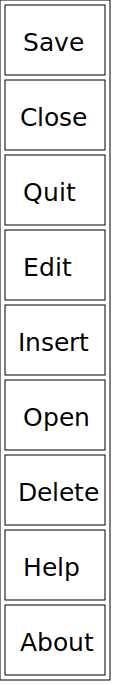

In [6]:
#solve the problem
layout, objective, runtime = solve(elements, positions, frequency, distance)
 
#Print the solution
print("Runtime:", runtime)

print("Objective value (expected selection time):", objective)

#plot the layout
SVGlayout = render.SVGlayout(layout,1)
SVG(SVGlayout.inSVG)

Gurobi Output explained: 

`Optimize a model with 18 rows, 81 columns and 162 nonzeros 
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]`<br>
Statistics about the to-be-solved problem: the number of constraints (rows), the decisions variables (columns) and properties about their values.

`Found heuristic solution: objective 1.424
Presolve time: 0.01s
Presolved: 18 rows, 81 columns, 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)`<br>
Objective value of a solution found via heuristics, the time to simplify (presolve) the problem and statistics of the simplified problem

`Root relaxation: objective 9.240000e-01, 38 iterations, 0.00 seconds`<br>
The objective value of the *relaxed* version of the problem. 

`    Nodes       |    Current Node    |     Objective Bounds      |    Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
   0     0               0         0.9240000    0.92400  0.00%     -    0s`<br>
The number of explored and unexplored nodes in the enumerative tree, information about the current node, 
the objective value of the current incumbent solution, the best bound found so far, and the corresponding gap, The number of simplex iterations used per node to solve the realxation, and the time used so far for solving the problem


`Explored 0 nodes (38 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)`<br>
Information about the performance. 

`Solution count 2: 0.924 1.424 
Pool objective bound 0.924`<br>
The objective values of the last X incumbent solutions and the best bound found for them. 

`Optimal solution found (tolerance 1.00e-04)
Best objective 9.240000000000e-01, best bound 9.240000000000e-01, gap 0.0000%`<br>
If an optimal solution was found, the best objective value, best bound, and corresponding gap. 

### Model-data separation
Above, we have first implemented the model and then defined the concrete problem instance with elements, positions, and the corresponding cost factors.

A clean separation between the optimization model and the problem data (cost values, variables, etc.) is useful because: 
<ul>
<li> Makes it easy to switch between test data and a real system
<li> Allows to reuse optimization models for different instances
<li> Easily include data from different sources (database, files, generated, etc.)
<li> Good programing practice for more flexible and easier to understand code
</ul>

<div class="alert alert-block alert-success">
<h3> [10p] Exercise 2: Trading off different tasks</h3>
<p>Assume that you have two different user groups that use the menu in very different ways, i.e., for two different frequencies A (same as above) and B. </p>
    
| Element | Frequency A| Frequency B
|----------|------|------|
| Quit | 0.3| 0.15|
| About |0.2|0.01|
| Open|0.1|0.05|
| Save|0.1|0.3|
| Close|0.05|0.2|
| Help|0.02|0.02|
| Edit|0.08|0.15|
| Insert| 0.1| 0.09 |
| Delete | 0.05 | 0.03 |

**[3p] 2.1 Use the optimization model above to optimize a menu for frequency B. How does the menu differ, compared to frequency A? Why is this?** 

*the code is above*
</div>

<div class="alert alert-block alert-danger">

We compute

|Menu under...| Frequency A | Frequency B |
|-|---|---|
||Quit | Save |
||About | Close |
||Insert | Quit |
||Open | Edit |
||Save | Insert |
||Edit | Open |
||Close | Delete |
||Delete | Help |
||Help | About |

    
Clearly, the arrangement is completely different. While the reading time $r$ and distances $d_i$ stay constant over both computations, frequencies $p_i$ change. Consequently, more frequently used actions under data B are placed earlier in its menu than in A's and vice-versa. In both cases, the most frequent action, "Quit" and "Save" respectively, is placed first.

</div>

<div class="alert alert-block alert-success">

**[2p] 2.2 Express, mathematically, the objective function above so that it finds the best design for multiple user groups
    . Explain in a few sentences your objective.**
</div>

<div class="alert alert-block alert-danger">
 
Modify the existing formulation slightly: Given the existing $r$, and $d_j$, plus the usage frequencies $p'_{ik}$ for the $i$-th item in group $k\in\{1,2,\ldots,G\}$, define as the new cost $c'_{ij}$ the mean of per-group costs in the old model over all groups, i.e., $c'_{ij}= \frac {d_{j}\cdot r} G \cdot\sum_{k=1}^G p'_{ik}$. So, our new objective is
    
$$min \sum_{i=1}^N\sum_{j=1}^N \frac {d_{j}\cdot r} G \cdot\left(\sum_{k=1}^G p'_{ik}\right) \cdot x_{ij} $$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

</div>

<div class="alert alert-block alert-success">
    
**[3p] 2.3: Implement the new objective function and optimize a menu that is best for multiple groups**
</div>

<div class="alert alert-block alert-danger">

2.3. Complete the code block above (def solve(...)) Hint: the cost function needs to loop over the number of users, which can be gotten with len(frequency) . 

</div>


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 18 rows, 81 columns and 162 nonzeros
Model fingerprint: 0xaa693ba6
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.6653333
Presolve time: 0.00s
Presolved: 18 rows, 81 columns, 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)

Root relaxation: objective 8.520000e-01, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.8520000    0.85200  0.00%     -    0s

Explored 1 nodes (35 simplex iterations) in 0.01 s

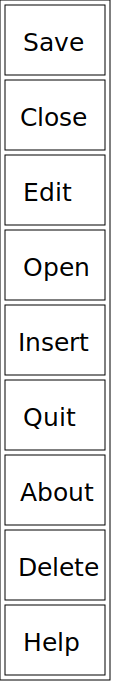

In [7]:
frequency = [{'Quit':0.05,'About':0.01,'Open':0.15,'Save':0.5,'Close':0.1,
             'Help':0.02,'Edit':0.05,'Insert':0.03,'Delete':0.09}, 
             {'Quit':0.15,'About':0.01,'Open':0.05,'Save':0.3,'Close':0.2,
             'Help':0.02,'Edit':0.15,'Insert':0.09,'Delete':0.03},
            {'Quit':0.01,'About':0.15,'Open':0.05,'Save':0.3,'Close':0.2,
             'Help':0.02,'Edit':0.15,'Insert':0.09,'Delete':0.03}]

#solve the problem
layout, objective, runtime = solve(elements, positions, frequency, distance, 'q2.3')

#Print the solution
print("Objective value (expected selection time):", objective)

#plot the layout
SVGlayout = render.SVGlayout(layout,1)
SVG(SVGlayout.inSVG)

<div class="alert alert-block alert-success">

**[2p] 2.4 What do you think would happen if different elements in your menu have a similar frequency?**

</div>

<div class="alert alert-block alert-danger">

Given that reading time is constant in our model, two elements of identical (mean) frequency have an identical cost associated for each $j$. Consequently, multiple optima exist and we can arbitrarily choose one.

In fact, we can see this happening in the above example. The mean frequency of "Insert" and "Quit" is $0.07$. We receive two solutions: one where "Insert" precedes "Quit" and one where "Quit" precedes "Insert."

</div>

# 4. Variations of the linear assignment problem
***

## 4.1 The generalized assignment problem
<img style="float:right;width=25%" src="imgs/gen_assignment_problem.PNG" >
Allows to model <i>capacities</i> for each agent so that each agent can be assigned multiple tasks. 


Scenario: An agent $i$ can work on multiple tasks but has a work capacity $t_i$. Assigning a task $j$ to an agent yields a profit $p_{ij}$ but also has a cost $c_{ij}$. 

Goal: Assign each task to exactly one agent such that the overall profit is maximized and no agent works more than his capacity allows. 



<table style="width:100%;font-size:11pt;">
    <tr style="background-color:#ffffff;">
        <td style="text-align:center;">
            <i><b>Linear assignment problem</b></i><br><br>
            $$min \sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij} $$
            $$\text{subject to} \hspace{6cm} $$
            $$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
            $$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
            $$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$
        </td>        
        <td style="text-align:center">
            <i><b>Generalized assignment problem</b></i><br><br>
            $$\color{red}{max}  \sum_{i=1}^N\sum_{j=1}^M \color{red}{p_{ij}} x_{ij} $$
            $$\text{subject to} \hspace{6cm} $$
            $$\sum_{i=1}^N x_{ij} = 1 \hspace{1cm} \forall j = 1 \ldots M$$
            $$\color{red}{\sum_{j=1}^n c_{ij} x_{ij} \leq t_i \hspace{0.55cm} \forall i = 1 \ldots N}$$
            $$ x_{ij} \in {0, 1} \hspace{1cm} \forall i = 1 .. N, j = 1 \ldots M$$
        </td>
    </tr>
</table>


In contrast to the linear assignment problem, the generalized assignment problem is NP-hard and can take very long to solve. 

However, there are simpler variations for which there efficient algorithms have been developed. For example, in the case where there is only one agent, the generalized assignment problem corresponds to the well-known <a href="https://en.wikipedia.org/wiki/Knapsack_problem">knapsack problem</a>. There the goal is to maximize the value of items you put in a backpack, without exceeding the capacity of the bag. 

## The generalized assignment problem in HCI

The generalized assignment problem is a useful extension of the linear assignment problem that allows us to model a capacity, for example of a UI element, instead of enforcing a one-to-one assignment. This can be applied to all kinds of problems, for example to model 
<ul>
    <li> the maximum size of a semantic group in a menu 
    <li> the screen space of a display or size of a GUI window    
    <li> the cognitive capacity of a user
</ul>


### Research example: Context-aware Online Adaptation of Mixed Reality Interfaces
[Lindlbauer, Feit, Hilliges, UIST 2019]

Optimization-based approach (using integer programming) for MR systems to automatically control *when* applications are shown,
*where* they should be displayed and *how* much information they should display.

<img src="imgs/cognitive_load.png" style="flot:left">

The basic optimization problem is to *maximize the utility* of the elements shown to the user which are constrained by the cognitive capacity of the user. Specifically, we estimate the user's current *cognitive load* $L_{est}$ (using the index of pupillary activity introduced by Duchowski et al., CHI 2018) and the elements potential cognitive cost. The objective function used in the paper is similar to the following knapsack problem:

$$max  \sum_{e=1}^N u_{e} x_{e} $$
$$\text{subject to} \hspace{6cm} $$           
$$L_{est} + \sum_{e=1}^N c_{e} x_{e} \leq L_{max} \hspace{0.55cm} $$
$$x_{e} \in {0, 1} \hspace{1.3cm} \forall e = 1 \ldots N $$


Such an optimization-based approach would allow content creators to move from a purely manual workﬂow of content creation, where every situation has to be dealt with separately, to a ﬂexible assignment of task and applications. The system then ensures that users are displayed useful information and content at the right time, place and with the right level of detail, depending on their specific context.

<img src="imgs/quadr_ass_problem.PNG" style="float:right;width:35%">

## 4.2 The quadratic assignment problem
Allows to model relationships between the elements of the two sets. 

Scenario: We want to build factories across a country and have a set of locations where we can build them. We frequently need to transport goods between certain factories, thus it is important that these are close together. 

Goal: Assign each factory to a location so that the transport time of goods is minimal. 

In the linear assignment problem, we only considered costs that were independently defined for each factory-location assignment (each agent-task assignment). Here, we need to take into account the relation between two factory-location assignments. If many goods are transported from one factory to another, they should be assigned to locations that are close to each other.


### Problem formulation

<ol>
<li> Decision varibales:
$x_{ik} = 1$ if factory $i$ is assigned to location $k$, $0$ otherwise. 
<li> Constraints: <br>
At each location $k$ there must be exactly one factory $i$ :
$$\sum_{i=1}^N x_{ik} = 1 \quad \forall k = 1 \cdots N$$

Each factory $i$ must be assigned to exactly one location $k$:
$$\sum_{k=1}^N x_{ik} = 1 \quad \forall i = 1 \cdots N$$

</ol>

<img src="imgs/quadr_ass_problem2.PNG" style="float:right;width:30%">

3 . Objective function: <br>
In the example on the right, the cost for assigning factories 1 and 2 to locations 3 and 4 is: 
$$f_{12} \cdot d_{34} \cdot x_{13} \cdot x_{24}$$
To solve the optimization problem, we want to minimize this cost for all possible pairs of factories and locations. This is computed by: 
$$\color{red}{min \sum_{i=1}^n \sum_{j=1}^n \sum_{k=1}^n \sum_{l=1}^n f_{ij} \cdot d_{kl} \cdot x_{ik} \cdot x_{jl}} $$

Thus, we can take into account relationships between elements of each set by simply changing the objective formulation. Overall, we get the following problem formulation: 

$$\color{red}{min \sum_{i=1}^n \sum_{j=1}^n \sum_{k=1}^n \sum_{l=1}^n f_{ij} \cdot d_{kl} \cdot x_{ik} \cdot x_{jl}}$$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

## The quadratic assignment problem in HCI
<img style="float: right;margin-left:20pt;width:50%" src="imgs/amazon.PNG">


The quadratic assignment problem is useful if we want to model relationships between UI elements, for example with respect to:


<ul>
    <li> <b>User's interaction</b>, e.g. the search button is often clicked after entering text in the search field
    <li> <b>Functional, visual, or other similarity</b>, e.g. links to different supbages are placed in a row next to each other
    <li> <b>Aesthetics</b>, e.g. pictures are placed next to each other and vertically and horizontally aligned
<li> etc. 
</ul>



# 5. Keyboard optimization
<img style="float: right; width:40%" src="imgs/letter_assignment.png" >

## The letter assignment problem 

A prominent example of the quadratic assignment problem in HCI is the letter assignment problem: 

Scenario: How should we place N characters on the keys of a keyboard so that we can type fastest?

For 26 letters and 26 keys there are $26! > 10^{25} $ different mappings, way to many to manually search and test for the best one. 



<div class="alert alert-block alert-success">
<h3> [4p] Exercise 3a: Modeling the letter assignment problem</h3>

How can you model the problem of assigning characters to keyslots on a keyboard mathematically?
<ol>
<li> Define the decision variable (1p)
<li> Add the necessary constraints (1p)
<li> Formulate the objective function. (2p) 
</ol>
Make sure to define all variable you use, also explain your answers in plain english.

*Tip: consider the factory-location problem above. What does the "flow" between factories and the "distance" between locations correspond to in the keyboard case?*


<div class="alert alert-block alert-danger">
    
Let $N$ denote the number of keys we wish to populate with letters.

Decision variables:
$x_{ik} = 1$ if letter $i$ is assigned to key $k$, $0$ otherwise. 

</div>

<div class="alert alert-block alert-danger">

Constraints:
    
On each key $k$ there must be exactly one letter $i$ :
$$\sum_{i=1}^N x_{ik} = 1 \quad \forall k = 1 \cdots N$$

Each letter $i$ must be assigned to exactly one key $k$:
$$\sum_{k=1}^N x_{ik} = 1 \quad \forall i = 1 \cdots N$$

</div>

<div class="alert alert-block alert-danger">

Objective function:

Let $f_{ij}$ denote the probability of letter $j$ appearing after letter $i$ in the typed language, i.e., $f_{ij}=\textit{bigram_frequency}(\textit{letter}(i)\textit{letter}(j))$,

<br>
    
Let $d_{kl}$ denote the time required to move from key $l$ to key $k$ according to Fitt's Law (in the Shannon formulation), i.e., $d_{kl}=a + b \cdot \log_2\left(\frac {D_{kl}} W + 1\right)$ with empirically found parameters $a,b$, key width $W$, and $D_{kl}=||\textit{pos}(k) - \textit{pos}(l)||$.
    
<br>

We want to minimize the cost $c_{ijkl} = f_{ij} \cdot d_{kl}$ for all possible pairs $(i,j)$ of letters and $(k,l)$ of keys. This sets the objective function to
    
$$min \sum_{i=1}^n \sum_{j=1}^n \sum_{k=1}^n \sum_{l=1}^n f_{ij} \cdot d_{kl} \cdot x_{ik} \cdot x_{jl} $$

The problem formulation follows naturally.    

</div>

<div class="alert alert-block alert-success">
<h3> [5p] Exercise 3b: Optimize a 9-key- keyboard</h3>
Implement the model in Gurobi by completing the code below. Run the code snippet afterwards to optimize a keyboard layout for the given letters.
  
 <i> Tip: follow the example code of the linear menu problem </i>
 <i> Tip 2: It prints words per minute </i>
</div>

<div class="alert alert-block alert-danger">
Complete the code block below.
</div>

In [8]:
# ANSWER TO Q3 B

def solve(characters, keyslots, bigram_frequency, movement_time):
    # ==== 1. Create the (empty) model ====
    model = Model("keyboard")
    
    # ==== 2. Add decision variables ======
    x = {}
        
    for i in characters:        
        for k in keyslots:
            x[(i,k)] = model.addVar(vtype=GRB.BINARY, name="%s_%i"%(i,k))
                
                
    # Integrate new variables
    model.update()    
    
    # ====3. Add Constraints ======
    # Each letter is only assigned to one keyslot
    for i in characters:
        model.addConstr(quicksum(x[(i,k)] for k in keyslots) == 1, "uniqueness_constraint_%s"%i)  
        
    # Each keyslot is only assigned to one letter
    for k in keyslots:
        model.addConstr(quicksum(x[(i,k)] for i in characters) == 1, "uniqueness_constraint_%i"%k)  
        
  
    model.update()
    
    # ==== 4. Specify Objective function ======    
    cost = quicksum(bigram_frequency[(i,j)] * movement_time[(k,l)] * x[(i,k)] * x[(j,l)]
                                for l in keyslots
                                    for k in keyslots
                                        for j in characters
                                           for i in characters)
    model.setObjective(cost,GRB.MINIMIZE)
    # ==== 5. Optimize model ======    
    model.optimize()
    
    # ====6. Extract solution ======   
    mapping = {}
    
    for v in model.getVars():
        if v.x == 1:
            character = v.varName.split("_")[0]
            slot = int(v.varName.split("_")[1])
            mapping[character] = slot
            
    return mapping, model.getObjective().getValue(), model.Runtime

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 18 rows, 81 columns and 162 nonzeros
Model fingerprint: 0x549cdcb5
Model has 3195 quadratic objective terms
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-06, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.2702377
Presolve time: 0.00s
Presolved: 18 rows, 81 columns, 162 nonzeros
Presolved model has 3204 quadratic objective terms
Variable types: 0 continuous, 81 integer (81 binary)

Root relaxation: objective -7.630190e-01, 103 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

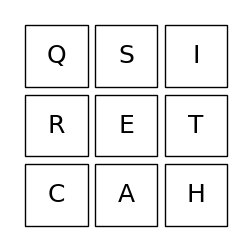

In [9]:
# DO NOT CHANGE ANYTHING BELOW HERE. This is the input data to the model.
# If the solve function is implemented correctly, running this code will optimize a keyboard layout for 9 characters.
# This should only take about 5 seconds

characters = ['a', 'c', 's', 'r', 'e', 'q', 't', 'h', 'i']

keyslots = list(range(len(characters))) 
columns = 3

#obtain cost factors: movement time and bigram frequencies
movement_time = {(s1,s2): utils.fittslawcost(s1,s2, utils.distance(columns,s1,s2)) for s1 in keyslots for s2 in keyslots}

#letter pair frequency        
bigram_frequency = utils.get_bigram_frequency(characters)

#solve the problem
mapping, objective, runtime = solve(characters, keyslots, bigram_frequency, movement_time)

print("The average WPM of the winning keyboard is %.2f"%utils.wpm(objective))
render.plot_keyboard(mapping, columns)

<div class="alert alert-block alert-success">

<h3> [5p] Exercise 4: Optimize a n-key-keyboard</h3>
 Above we limited ourselves to 9 keys. We also already stated that this is a np-hard problem.
This means that the complexity greatly increases with the number of keys.

**[3p] 4a. Below, using a for-loop, matplotlib and the solve() function, plot the solve time for different amount of keys.**
</div>

<div class="alert alert-block alert-danger">

Answer for Exercise 4a in the code block below.

</div>

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 0 rows, 0 columns and 0 nonzeros
Model fingerprint: 0xf9715da1
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2 rows, 1 columns and 2 nonzeros
Model fingerprint: 0x9edbf467
Model has 1 quadratic objective term
Variable types: 0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00109    0   12    0.01770    0.00109  93.8%     -    0s
H    0     0                       0.0173481    0.00109  93.7%     -    0s
     0     0    0.00109    0   12    0.01735    0.00109  93.7%     -    0s
H    0     0                       0.0173033    0.00109  93.7%     -    0s
H    0     0                       0.0169675    0.00109  93.6%     -    0s
     0     0    0.00814    0   12    0.01697    0.00814  52.0%     -    0s
     0     0    0.00820    0   12    0.01697    0.00820  51.7%     -    0s
H    0     2                       0.0168359    0.00820  51.3%     -    0s
     0     2    0.00820    0   12    0.01684    0.00820  51.3%     -    0s
H   23     9                       0.0168315    0.01380  18.0%  55.3    0s
*   40     4               7       0.0167827    0.01478  11.9%  43.0    0s
*   50     0              10       0.0167740    0.01677  0.00%  36.4    0s

Cutting planes:
  RLT

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0497052
Presolve time: 0.01s
Presolved: 20 rows, 100 columns, 200 nonzeros
Presolved model has 4950 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective -2.320492e-01, 124 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       0.0471022    0.00000   100%     -    0s
     0     0    0.00114    0   97    0.04710    0.00114  97.6%     -    0s
H    0     0                       0.0468860    0.00114  97.6%     -    0s
     0     0    0.00114    0   97    0.04689    0.00114  97.6%     -    0s
H    0     0                       0.0456654    0.00114  97.5%     -    0s
H    0     2                       0.0449585    0.00114  97.5%     -    0s
     0     2    0.001


Optimal solution found (tolerance 1.00e-04)
Best objective 6.105488792796e-02, best bound 6.105193626104e-02, gap 0.0048%


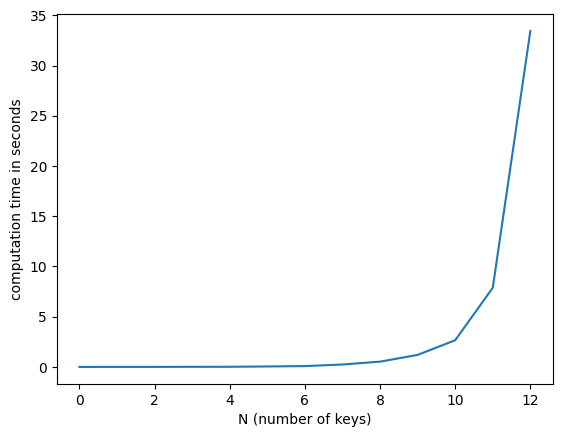

In [10]:
import matplotlib.pyplot as plt
solvetimes = []

characters = [chr(idx) for idx in range(97,123)] # ['a', 'b', ..., 'z']
keyslots = list(range(len(characters)))
movement_time = {(s1,s2): utils.fittslawcost(s1,s2, utils.distance(columns,s1,s2)) for s1 in keyslots for s2 in keyslots}
bigram_frequency = utils.get_bigram_frequency(characters)

lidx, runtime = 0, 0
while runtime < 10: # Repeat until it takes an uncomfortably long time.
    _, _, runtime = solve(characters[:lidx], list(range(lidx)), bigram_frequency, movement_time)
    solvetimes.append(runtime)
    lidx += 1

plt.plot(solvetimes)
plt.xlabel("N (number of keys)")
plt.ylabel("computation time in seconds")
plt.show()

<div class="alert alert-block alert-success">


**[2p] 4b. What conclusions can you draw from these results?**
</div>

<div class="alert alert-block alert-danger">

The computation time seems to grow exponentially when increasing the number of keys $N$. This is in accordance with the previous remark that the generalized assignment problem is NP-hard.

Consequently, one should be mindful of the problem size when designing such optimization scenarios. Every additional decision variable increases the computational burden by the order of its old magnitude.

</div>

# 8. Conclusion

Integer programming is an exact method for solving optimization problems. 
- guarantees to find the optimal solution and gives bounds on the goodnness of intermediate solutions
- requires mathematical formulation of the problem 
- fast and easy to implement with Gurobi
- classical 

The mathematical formulation is critical and key to using standard solvers efficiently. We have seen one class of classical problems - assignment problems. Many design problems in HCI can be cast as assignment problems, but there are also other problem classes in combinatorial optimization which can be useful to know about when trying to abstract a design problem. See for example <a href="https://en.wikipedia.org/wiki/Combinatorial_optimization#Specific_problems">here</a>.

For computationally complex optimization problems (e.g. QAPs), it can be useful to work with optimization experts, e.g. from your university. They often know a lot of "tricks" and might be able to reformulate your problem or know how to exploit its structure to solve it faster. 

# Links and references

Integer Programming and Combinatorial Optimization: 
- Rao, S.R. Engineering Optimization: Theory and Practice. John Wiley & Sons, 2009.
- Wolsey, Laurence A. Integer Programming. Wiley, 1998.
- Oulasvirta., A. & Karrenbauer, A. <a href="https://www.oxfordscholarship.com/view/10.1093/oso/9780198799603.001.0001/oso-9780198799603-chapter-5">Combinatorial Optimization for Interface Design</a>, in "Computational Interaction", Oxford University Press, 2018.

Selected research that uses Integer Programming to solve HCI problems
- Anna Maria Feit. 2018. <a href="https://aaltodoc.aalto.fi/handle/123456789/31312"> Assignment Problems for Optimizing Text Input.</a> Doctoral Dissertation, Aalto University. 
- Andreas Karrenbauer and Antti Oulasvirta. 2014. <a href="http://resources.mpi-inf.mpg.de/keyboardoptimization/">Improvements to keyboard optimization with integer programming.</a> In Proc. UIST '14. ACM
- Seonwook Park et al. 2018 <a href="https://ait.ethz.ch/projects/2018/adam/">AdaM: Adapting Multi-User Interfaces for Collaborative Environments in Real-Time</a> in Proc. CHI'18. ACM
- David Lindlbauer, Anna Maria Feit, and Otmar Hilliges. 2019. <a href="https://ait.ethz.ch/projects/2019/computationalMR/downloads/computationalMR_preprint.pdf">Context-Aware Online Adaption of Mixed Reality Interfaces</a> In Proc. UIST '19. ACM

Weblinks
- Integer Program solvers: <a href="https://www.gurobi.com"> Gurobi </a> or <a href="https://www.ibm.com/analytics/cplex-optimizer"> IBM's CPLEX</a> (both are free for academic use)